# Forecasting Univariate Time Series using LTSM

### Using LTSM for predicting House Prices from a raw set of data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## About The Data

The data consists of new one family houses sold in the United States in thousands of units, retrieved from FRED, Federal Reserve Bank of St. Louis.

*Data Source:* U.S. Census Bureau and U.S. Department of Housing and Urban Development, New One Family Houses Sold: United States HSN1F, retrieved from FRED, Federal Reserve Bank of St. Louis.

link: https://fred.stlouisfed.org/series/HSN1F, March 3

In [2]:
# Loading the data into a pandas dataframe
houseSales = pd.read_csv('/content/data/one_family_houses.csv')
houseSales.head(3)

,Date,Sales
0,1/1/1963,591
1,2/1/1963,464
2,3/1/1963,461


As the data was already clean and the only paramers we need here is Date and Sales, the next step is to get to analytics.

In [3]:
# Scaling the data between [0, 1]
scaler = MinMaxScaler()
scaler.fit(houseSales.Sales.values.reshape(-1, 1))
houseSalesScaled = scaler.transform(houseSales.Sales.values.reshape(-1, 1))
houseSales['HouseSalesScaled'] = houseSalesScaled

## Descriptive Statistics of House Sales and Charts.

In [4]:
# Details about the data
houseSales.describe()

,Sales,HouseSalesScaled
count,697.000000,697.000000
mean,654.005739,0.343169
std,211.685830,0.189174
min,270.000000,0.000000
25%,510.000000,0.214477
50%,625.000000,0.317248
75%,767.000000,0.444147
max,1389.000000,1.000000


Line plots of house sales.

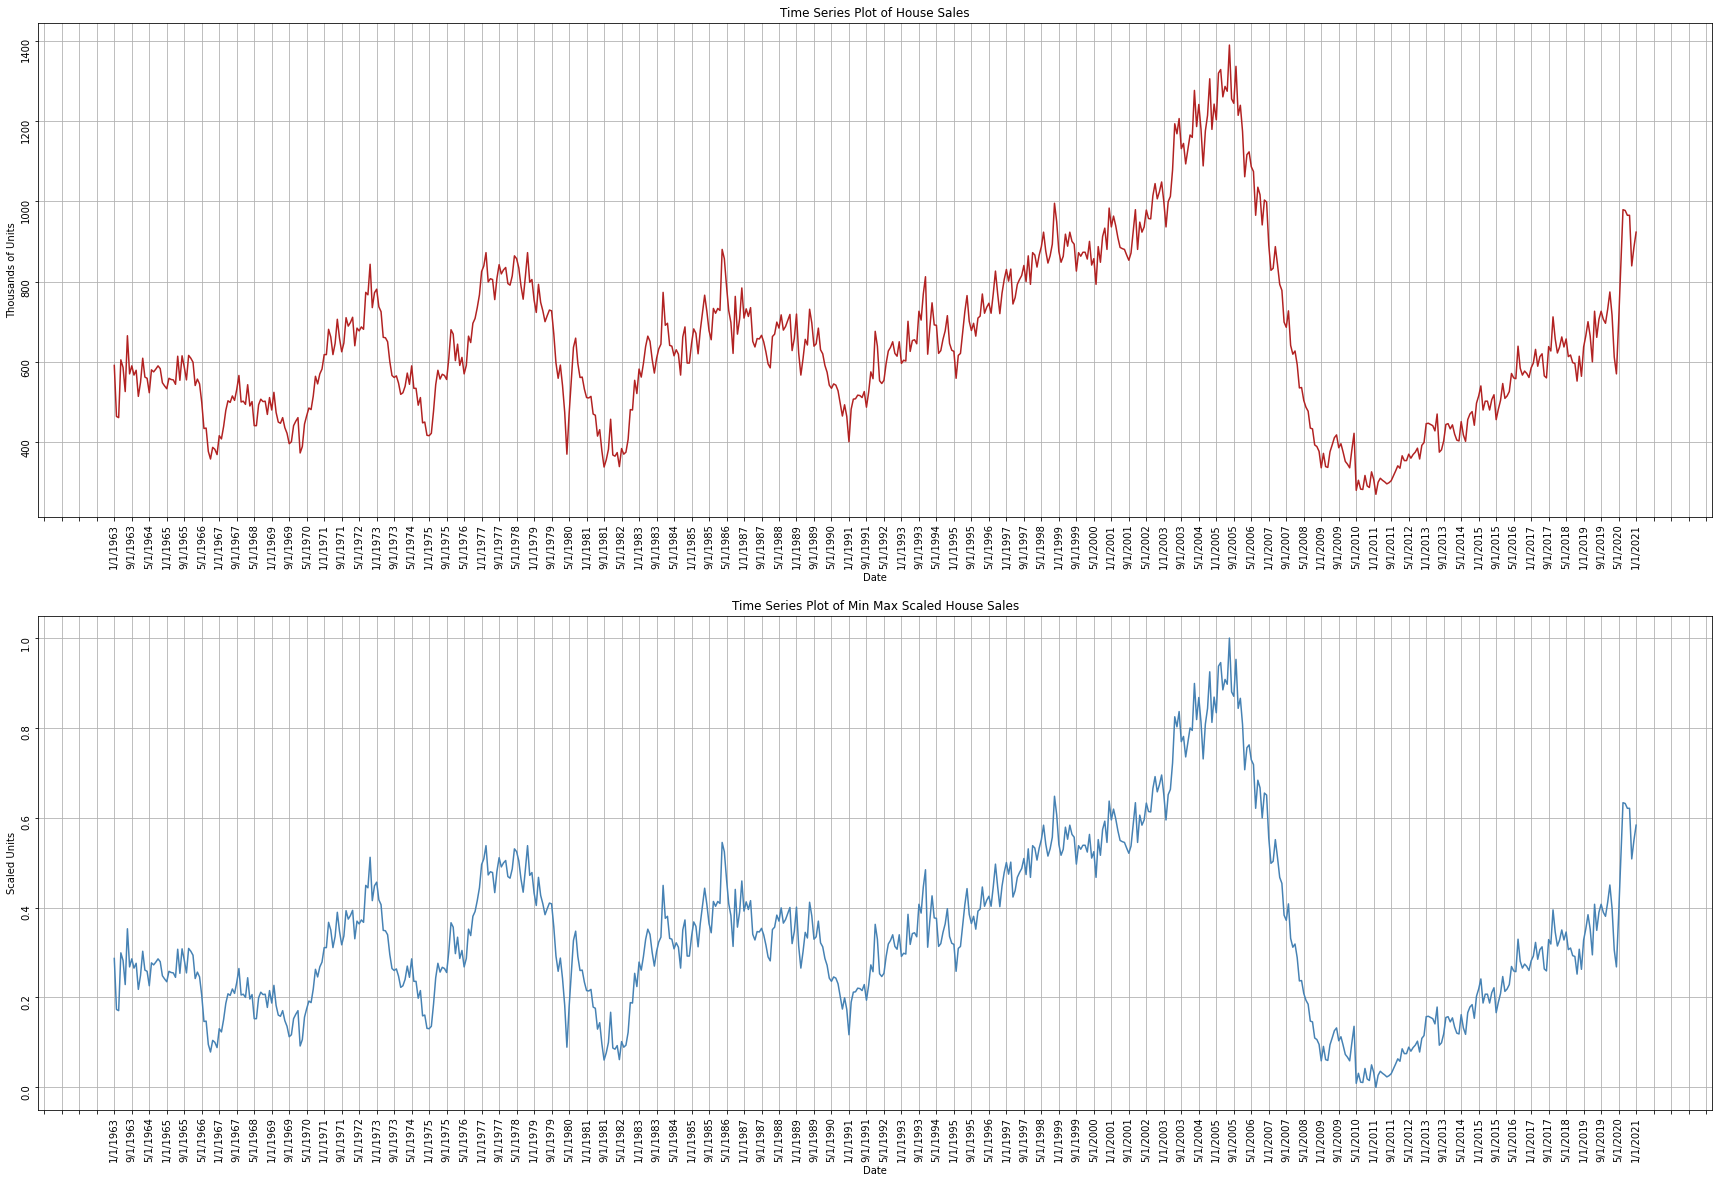

In [5]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(houseSales.Date, houseSales.Sales, 'firebrick')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(houseSales.Date, houseSales.HouseSalesScaled, 'steelblue')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)

plt.savefig('plots/image1.png')
plt.show()

The histogram of the house Sales.

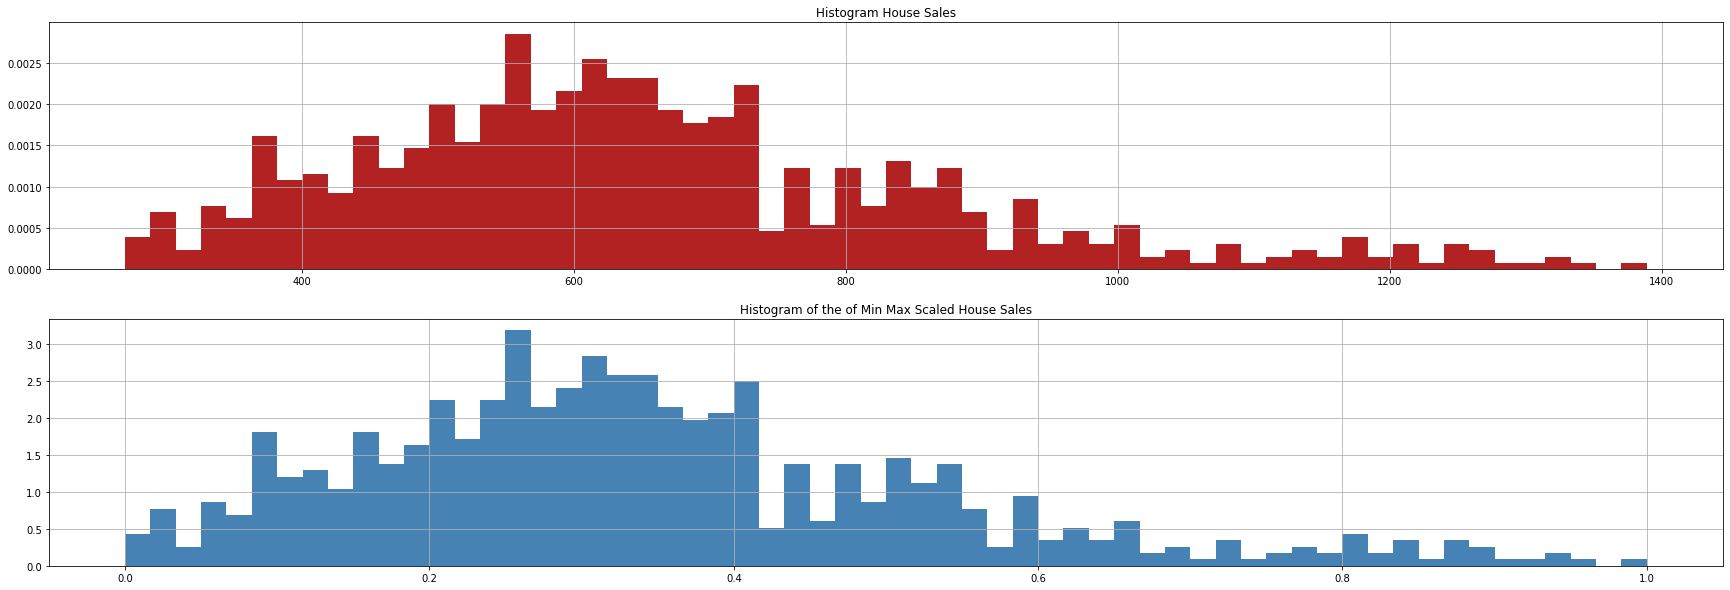

In [6]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(houseSales.Sales, density=True, bins=60, facecolor='firebrick')
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(houseSales.HouseSalesScaled, density=True, bins=60, facecolor = 'steelblue')
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)

plt.savefig('plots/image2.png')
plt.show()

## Unit Root Test and Autocorrelogram.

In [7]:
result = adfuller(houseSales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.808552072554989
p-value: 0.05706251126952978
Critial Values:
   1%, -3.4400605106273368
Critial Values:
   5%, -2.865824986587412
Critial Values:
   10%, -2.5690518865761


In [8]:
result = adfuller(houseSales.HouseSalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.808552072555018
p-value: 0.05706251126952565
Critial Values:
   1%, -3.4400605106273368
Critial Values:
   5%, -2.865824986587412
Critial Values:
   10%, -2.5690518865761


In [9]:
acfSalesScaled = acf(houseSales.HouseSalesScaled, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

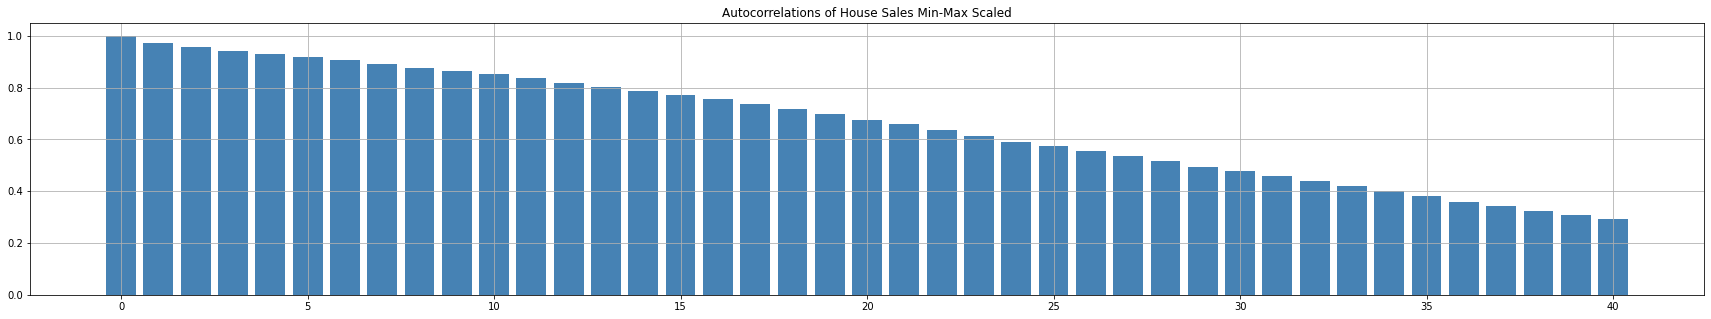

In [10]:
plt.figure(figsize=(30, 5))
plt.title("Autocorrelations of House Sales Min-Max Scaled")
plt.bar(range(len(acfSalesScaledNp)), acfSalesScaledNp, facecolor = 'steelblue')
plt.grid(True)

plt.savefig('plots/image3.png')
plt.show()

In [11]:
pacfSalesScaled = pacf(houseSales.HouseSalesScaled, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

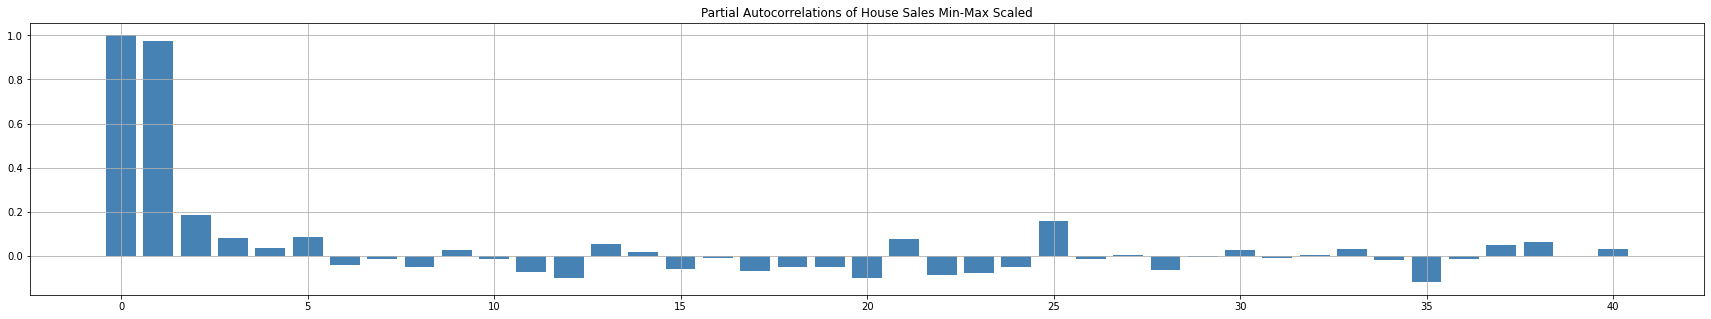

In [12]:
plt.figure(figsize=(30, 5))
plt.title("Partial Autocorrelations of House Sales Min-Max Scaled")
plt.bar(range(len(pacfSalesScaledNp)), pacfSalesScaledNp, facecolor = 'steelblue')
plt.grid(True)
plt.savefig('plots/image4.png')

plt.show()

## Separating the data into a Training and a validation (Test) set and formatting for estimation with an LSTM.

In [13]:
SIZE = len(houseSales.HouseSalesScaled)
WINDOW_SIZE = 48  # 4 Years of Data
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

Separating the data in training and a validation datasets.

In [14]:
DateTrain = houseSales.index.values[0:BATCH_SIZE]
DateValid = houseSales.index.values[BATCH_SIZE:]
XTrain = houseSales.HouseSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = houseSales.HouseSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (601, 1)
Shape of the validation set date series:  (96, 1)
Shape of the training set logarithm of sales series:  (601,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [15]:
tf.random.set_seed(1213) # Giving a random seed

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
  
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)
  
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

## LSTM Estimation and Forecasting.

In [16]:
model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(8, input_shape=[None, 1], return_sequences=True),
tf.keras.layers.LSTM(4, input_shape=[None, 1]),
tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


The Huber Loss is chosen because it is quite robust for non linear regression models and models with non-normal errors.

In [17]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='huber_loss', optimizer=optimizer)
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.2144 - val_loss: 0.1913
Epoch 2/200
1/1 [==============================] - 0s 456ms/step - loss: 0.2063 - val_loss: 0.1827
Epoch 3/200
1/1 [==============================] - 0s 429ms/step - loss: 0.1983 - val_loss: 0.1742
Epoch 4/200
1/1 [==============================] - 0s 385ms/step - loss: 0.1904 - val_loss: 0.1658
Epoch 5/200
1/1 [==============================] - 0s 397ms/step - loss: 0.1824 - val_loss: 0.1574
Epoch 6/200
1/1 [==============================] - 0s 323ms/step - loss: 0.1745 - val_loss: 0.1490
Epoch 7/200
1/1 [==============================] - 0s 439ms/step - loss: 0.1667 - val_loss: 0.1407
Epoch 8/200
1/1 [==============================] - 1s 523ms/step - loss: 0.1588 - val_loss: 0.1324
Epoch 9/200
1/1 [==============================] - 1s 582ms/step - loss: 0.1510 - val_loss: 0.1242
Epoch 10/200
1/1 [==============================] - 0s 453ms/step - loss: 0.1432 - val_loss: 0.1161
Epoch 11/200

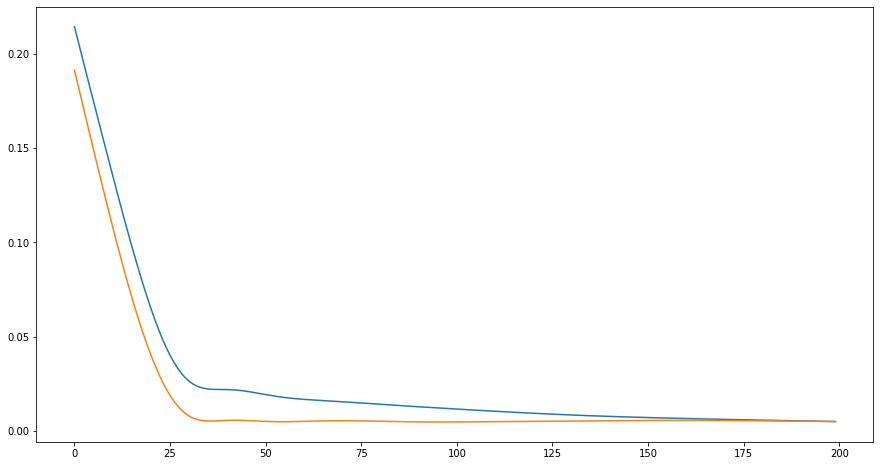

In [18]:
fig = plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.savefig('plots/image5.png')
plt.show()

In [19]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

Forecast = model_forecast(model, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

LSTM Line plot of forecast vs. Line plot of validation set.

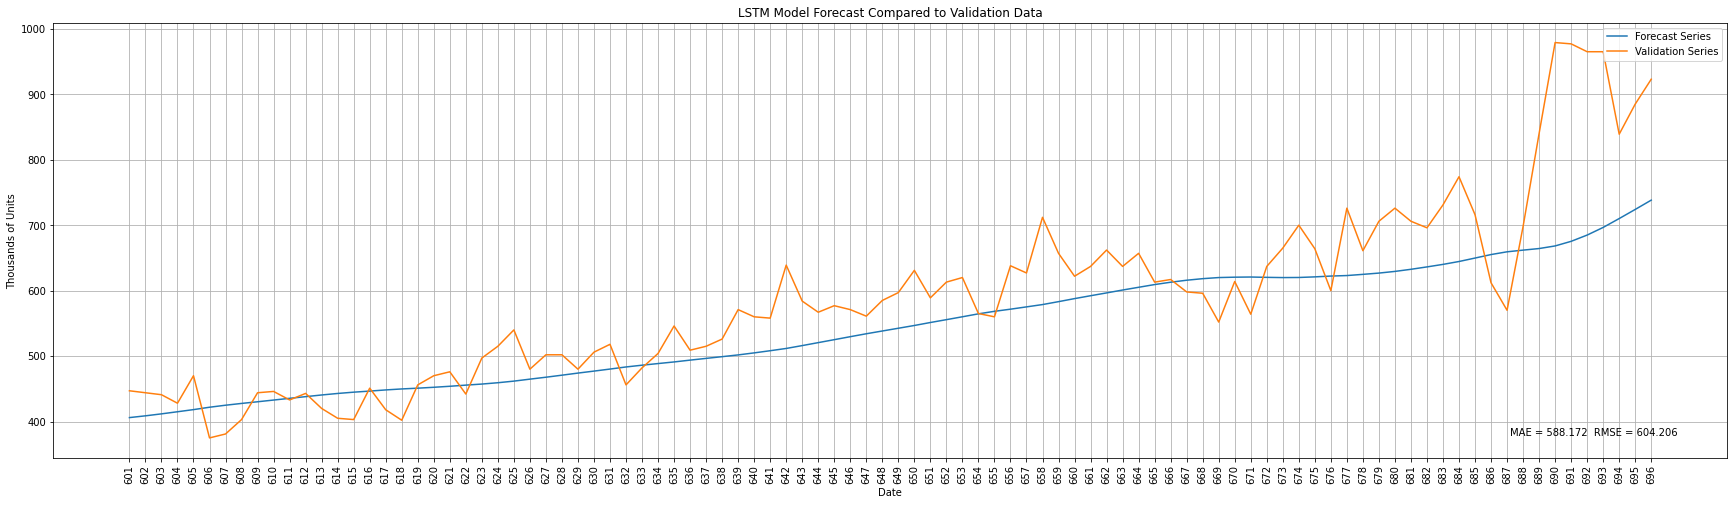

In [20]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid, Results1, label='Forecast Series')
plt.plot(DateValid, np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation Series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.savefig('plots/image6.png')
plt.show()

## Conclusion

In conclusion, it is verified that the LTSM Model is predicting the sales almost correctly fitting just in between the actual results.

In comparison, a Regression model would've been worse for predicting this type of scenario where the data values are drastically changing at points.